In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,StandardScaler
from seaborn import countplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Models to be used for experimentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

#Put seed for same experiment outcomes
from numpy.random import seed
seed(1)

# 1. Load the data file

In [2]:
raw_df = pd.read_csv('C:\\Users\\dubs\\Desktop\\KAGGLE\\GameRatingsESRBDataSet\\archive\\Video_games_esrb_rating.csv',delimiter=',')
columns = raw_df.columns.values
print('Column names: ',columns)
print('-----\n')

esrb_rating_labels = raw_df.esrb_rating.unique()
print('Rating Labels: ',esrb_rating_labels)
print('-----\n')

descriptors = columns[1:-1]
print('Independent Variables: ',descriptors) 

Column names:  ['title' 'console' 'alcohol_reference' 'animated_blood' 'blood'
 'blood_and_gore' 'cartoon_violence' 'crude_humor' 'drug_reference'
 'fantasy_violence' 'intense_violence' 'language' 'lyrics' 'mature_humor'
 'mild_blood' 'mild_cartoon_violence' 'mild_fantasy_violence'
 'mild_language' 'mild_lyrics' 'mild_suggestive_themes' 'mild_violence'
 'no_descriptors' 'nudity' 'partial_nudity' 'sexual_content'
 'sexual_themes' 'simulated_gambling' 'strong_janguage'
 'strong_sexual_content' 'suggestive_themes' 'use_of_alcohol'
 'use_of_drugs_and_alcohol' 'violence' 'esrb_rating']
-----

Rating Labels:  ['E' 'ET' 'M' 'T']
-----

Independent Variables:  ['console' 'alcohol_reference' 'animated_blood' 'blood' 'blood_and_gore'
 'cartoon_violence' 'crude_humor' 'drug_reference' 'fantasy_violence'
 'intense_violence' 'language' 'lyrics' 'mature_humor' 'mild_blood'
 'mild_cartoon_violence' 'mild_fantasy_violence' 'mild_language'
 'mild_lyrics' 'mild_suggestive_themes' 'mild_violence' 'no_des

In [3]:
X = raw_df[descriptors].to_numpy()

le = LabelEncoder()
y = le.fit_transform(raw_df['esrb_rating'].to_numpy())
y

array([0, 1, 2, ..., 0, 3, 0])

# 2. Let's look at the correlations between the vairables

Text(0.5, 1.0, 'Correlation Matrix')

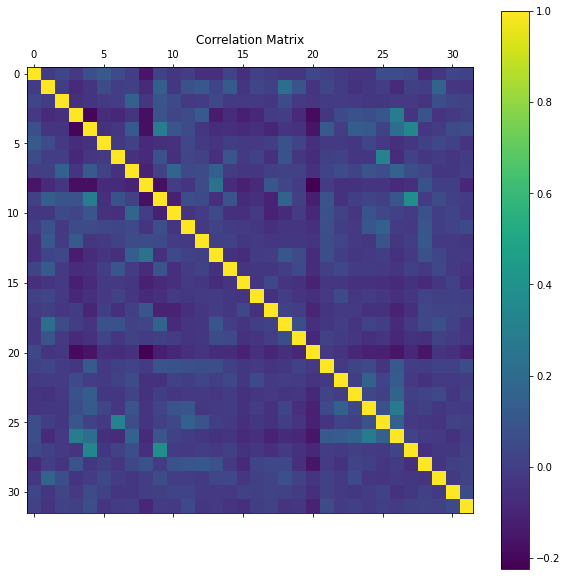

In [4]:
f = plt.figure(figsize=(10,10))
plt.matshow(raw_df[descriptors].corr(),fignum=f.number)
cb = plt.colorbar()
plt.title('Correlation Matrix')

In [5]:
print('We don\'t see much correlation between the variables other than themselves.' )
raw_df[descriptors].corr().style.background_gradient(cmap='coolwarm')

We don't see much correlation between the variables other than themselves.


,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,lyrics,mature_humor,mild_blood,mild_cartoon_violence,mild_fantasy_violence,mild_language,mild_lyrics,mild_suggestive_themes,mild_violence,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
console,1.000000,-0.010502,0.031460,-0.018638,0.074368,0.117672,0.060719,-0.002193,-0.149703,0.014717,-0.025412,0.000271,-0.053862,-0.057120,0.025013,-0.055683,0.010938,-0.005617,-0.030490,-0.028773,0.041926,0.014775,-0.017471,-0.034284,-0.035514,0.065992,0.063812,0.043566,-0.072237,-0.027630,0.031628,0.010672
alcohol_reference,-0.010502,1.000000,0.001153,-0.078723,-0.036286,0.054970,-0.001745,0.009118,-0.075557,0.148086,-0.025514,0.078798,0.110553,0.022633,0.122995,-0.040287,0.032322,0.006173,0.220757,0.096508,-0.039551,0.031995,-0.005368,-0.043297,-0.025596,-0.003547,-0.076622,0.007684,-0.001347,0.164599,-0.029137,-0.040217
animated_blood,0.031460,0.001153,1.000000,-0.054686,-0.038232,-0.014202,-0.000764,0.154219,-0.027989,0.094402,0.050214,-0.018662,-0.010907,0.034883,-0.015696,-0.022603,-0.014966,-0.029076,0.055530,-0.022472,-0.031429,-0.012324,-0.011636,-0.018967,-0.024862,-0.026972,-0.020440,-0.019415,-0.036753,0.072105,0.029670,0.017046
blood,-0.018638,-0.078723,-0.054686,1.000000,-0.206437,-0.067592,-0.080343,-0.041479,-0.173801,0.089358,0.033477,0.060607,0.117246,-0.128925,-0.068227,-0.116163,-0.080808,-0.006054,-0.000913,-0.079941,-0.185570,-0.024845,0.047414,0.084194,0.071050,0.105880,0.291957,-0.037207,0.090421,-0.038687,-0.018533,0.007284
blood_and_gore,0.074368,-0.036286,-0.038232,-0.206437,1.000000,-0.042122,-0.027978,0.118566,-0.171432,0.289246,0.097976,0.053680,-0.026334,-0.066487,-0.059250,-0.077890,-0.056494,-0.091879,-0.035481,-0.047463,-0.159186,0.124743,-0.002132,0.138011,0.124611,0.012603,0.220318,0.336910,-0.025282,-0.009979,0.053693,0.063320
cartoon_violence,0.117672,0.054970,-0.014202,-0.067592,-0.042122,1.000000,-0.017009,0.014797,-0.075072,-0.051667,-0.049149,0.037654,-0.015294,-0.038613,0.003040,-0.013856,-0.020985,0.002136,0.080791,0.022285,-0.053692,-0.017282,-0.016317,-0.026596,0.030661,-0.022569,-0.051667,-0.027225,0.007645,0.043213,0.012657,-0.036855
crude_humor,0.060719,-0.001745,-0.000764,-0.080343,-0.027978,-0.017009,1.000000,-0.045542,-0.077018,0.085252,-0.061018,0.033442,0.017475,-0.056458,0.100194,-0.021187,0.012343,-0.060539,0.084074,-0.031647,-0.065087,0.009223,0.013080,-0.032395,-0.029236,0.317392,-0.066149,0.016318,-0.029767,-0.011759,-0.030407,-0.005491
drug_reference,-0.002193,0.009118,0.154219,-0.041479,0.118566,0.014797,-0.045542,1.000000,-0.101056,0.019599,0.174765,0.045046,0.060019,0.140227,-0.010724,-0.029203,-0.028249,0.009876,0.015025,0.011711,-0.047628,0.024447,0.053712,0.027456,0.089050,0.064191,0.162238,0.071671,0.037812,-0.024093,-0.024093,-0.002522
fantasy_violence,-0.149703,-0.075557,-0.027989,-0.173801,-0.171432,-0.075072,-0.077018,-0.101056,1.000000,-0.167181,-0.000897,-0.034761,0.061154,0.234389,-0.066252,-0.113529,-0.079111,0.099248,0.033831,-0.011083,-0.223748,-0.012407,-0.050356,-0.044318,-0.038499,-0.040787,-0.072573,-0.054735,0.082195,0.003901,0.003901,-0.086881
intense_violence,0.014717,0.148086,0.094402,0.089358,0.289246,-0.051667,0.085252,0.019599,-0.167181,1.000000,-0.111730,0.068863,0.051871,-0.055239,0.093188,-0.074587,-0.054447,-0.105783,0.167331,0.010463,-0.122131,0.090633,-0.042334,0.002844,0.021872,0.006457,0.098834,0.386323,-0.006898,0.058322,0.005943,-0.008710


# 2. Let's look at the rating class distribution


It seems that the classes are almost balanced hence we won't try to up or down sample the classes


C:\Users\dubs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='esrb_rating', ylabel='count'>

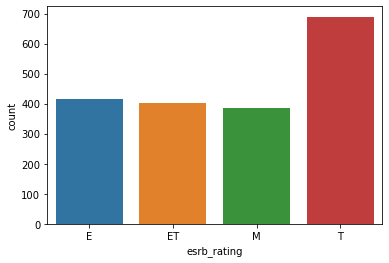

In [6]:
print('It seems that the classes are almost balanced hence we won\'t try to up or down sample the classes')
countplot(raw_df['esrb_rating'])

# 3. Now we try to see if we can find any separation in the clusters for rating types when least components are used in PCA

In [7]:
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)

NOTE:- We don't see much separation between the classes of ratings when we try to use least number of components. Hence PCA is not suitable


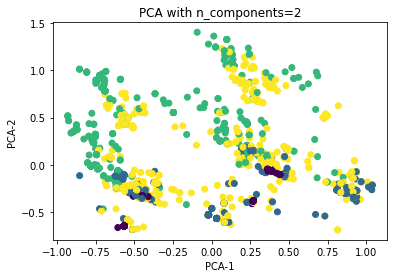

In [10]:
plt.scatter(pca_X[:,0],pca_X[:,1],c=y)
plt.title('PCA with n_components=2')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
print('NOTE:- We don\'t see much separation between the classes of ratings when we try to use least number of components. Hence PCA is not suitable')

# 4. Before we did PCA with n_components=2 and couldn't find clusterings. Let's see why it happened

This suggest us that we have to use almost all the variables instead of few. About 90% of data is in 23-25 components


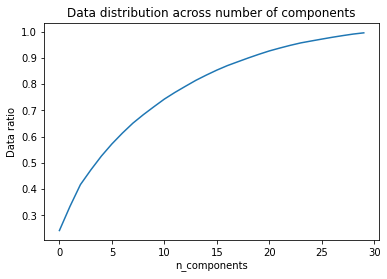

In [32]:
exp_var_ratio = []
components_list = []
for k in range(2,32):
    pca_k = PCA(n_components=k)
    pca_k.fit(X)
    exp_var_ratio.append(pca_k.explained_variance_ratio_)
    components_list.append(pca_k.components_)
    
exp_var_per = []
for v in exp_var_ratio:
    exp_var_per.append(np.sum(v))   
    

plt.plot(exp_var_per)
plt.title('Data distribution across number of components')
plt.xlabel('n_components')
plt.ylabel('Data ratio')
print('This suggest us that we have to use almost all the variables instead of few. About 90% of data is in 23-25 components')

In [53]:
"""
#Splitting the data into train and test sets
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Standardize the data first
sc = StandardScaler()
std_x_train = sc.fit_transform(x_train)
std_x_test = sc.transform(x_test)
"""

# 5. Let's experiment with several classifiers and see which one might do best

In [7]:
models = {'LR': LogisticRegression(),
          'SVM': SVC(),
          'RF': RandomForestClassifier(),
          'ADA': AdaBoostClassifier(),
          'GBM': GradientBoostingClassifier(),
          'DT': DecisionTreeClassifier(),
          'KNN':KNeighborsClassifier(),
          'QDA':QuadraticDiscriminantAnalysis(),
          'NB': GaussianNB(),
          'GDA':LinearDiscriminantAnalysis()}

In [8]:
def run_experiment(model_list,X,y):
    
    folds = KFold(n_splits=10, random_state=1,shuffle=True)
    print(folds)
    #Standardize the data first
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    model_names = []
    cv_results = []
    mean_score_list = []
    for model in models.keys():
        scores = cross_val_score(models[model],X,y,scoring='accuracy',cv=folds,n_jobs=-1)
        mean_score_list.append((model,'mean acc: '+str(np.mean(scores)),'std acc: '+str(np.std(scores))))
        print('model name: %s -- mean accuracy: %0.3f || std accuracy: %.3f '%(model,np.mean(scores),np.std(scores)))
        cv_results.append(scores)
        model_names.append(model)
    return model_names,mean_score_list,cv_results

In [9]:
model_names, mean_score_list, cv_results = run_experiment(models,X,y)

KFold(n_splits=10, random_state=1, shuffle=True)
model name: LR -- mean accuracy: 0.846 || std accuracy: 0.037 
model name: SVM -- mean accuracy: 0.863 || std accuracy: 0.031 
model name: RF -- mean accuracy: 0.853 || std accuracy: 0.023 
model name: ADA -- mean accuracy: 0.708 || std accuracy: 0.044 
model name: GBM -- mean accuracy: 0.846 || std accuracy: 0.034 
model name: DT -- mean accuracy: 0.845 || std accuracy: 0.027 
model name: KNN -- mean accuracy: 0.794 || std accuracy: 0.039 
model name: QDA -- mean accuracy: 0.563 || std accuracy: 0.037 
model name: NB -- mean accuracy: 0.562 || std accuracy: 0.038 
model name: GDA -- mean accuracy: 0.793 || std accuracy: 0.034 


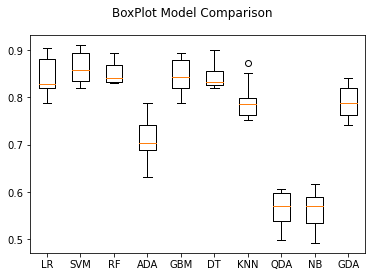

BEST MODELS:
-----
	LR, SVM, RF, GBM, DT

WORST MODELS:
-----
	ADA, KNN, QDA, GaussianNB, GDA


In [10]:
def boxplot_comparison(model_names,cv_results):
    
    fig = plt.figure()
    fig.suptitle('BoxPlot Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(cv_results)
    ax.set_xticklabels(model_names)
    plt.show()
    
boxplot_comparison(model_names,cv_results)
print('BEST MODELS:\n-----\n\tLR, SVM, RF, GBM, DT\n\nWORST MODELS:\n-----\n\tADA, KNN, QDA, GaussianNB, GDA')

# 6. Optimize best algorithms for better evaluation

In [11]:
models = ['LR','SVM','RF','GBM','DT']

clfs = [
        LogisticRegression(),
        SVC(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        DecisionTreeClassifier()
       ]

param_space = {
                models[0]:{'penalty':['l1','l2'], 'C':[0.001,0.01], 'solver':['lbfgs','saga'], 'max_iter':[100,200]},
                models[1]:{'C':[0.001,0.003,1,10], 'kernel':['rbf','linear']},
                models[2]:{'n_estimators':[100,150], 'criterion':['gini','entropy']},
                models[3]:{'learning_rate':[0.1,0.01],'n_estimators':[100,150]},
                models[4]:{'criterion':['gini','entropy']}
              }

In [12]:
def grid_optimization(models,clfs,param_space,X,y):
    
    #Standardize the data first
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    for name,estimator in zip(models,clfs):
        print(name)
        clf = GridSearchCV(estimator,param_space[name],scoring='accuracy',refit='True',cv=5)
        clf.fit(X,y)
        
        #print('best estimator: ',clf.best_estimator_)
        print('best params: ',clf.best_params_)
        print('best scores: %.3f'%clf.best_score_)
        print('-----\n')

In [13]:
grid_optimization(models,clfs,param_space,X,y)
print('Best models after optimisation are:\n-----\n\tSVM, GBM, RF')

LR


C:\Users\dubs\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dubs\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dubs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\dubs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\dubs\anaconda3\lib\site-packages\sklearn\model_selection\_valida

best params:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
best scores: 0.821
-----

SVM
best params:  {'C': 1, 'kernel': 'rbf'}
best scores: 0.859
-----

RF
best params:  {'criterion': 'entropy', 'n_estimators': 100}
best scores: 0.853
-----

GBM
best params:  {'learning_rate': 0.1, 'n_estimators': 150}
best scores: 0.857
-----

DT
best params:  {'criterion': 'entropy'}
best scores: 0.844
-----

Best models after optimisation are:
-----
	SVM, GBM, RF


# 7. Final evaluation on Test Data

In [14]:
test_raw_df = pd.read_csv('C:\\Users\\dubs\\Desktop\\KAGGLE\\GameRatingsESRBDataSet\\archive\\test_esrb.csv',delimiter=',')
columns = test_raw_df.columns.values
print('Column names: ',columns)
print('-----\n')

esrb_rating_labels = test_raw_df.esrb_rating.unique()
print('Rating Labels: ',esrb_rating_labels)
print('-----\n')

descriptors = columns[1:-1]
print('Independent Variables: ',descriptors) 

Column names:  ['title' 'console' 'alcohol_reference' 'animated_blood' 'blood'
 'blood_and_gore' 'cartoon_violence' 'crude_humor' 'drug_reference'
 'fantasy_violence' 'intense_violence' 'language' 'lyrics' 'mature_humor'
 'mild_blood' 'mild_cartoon_violence' 'mild_fantasy_violence'
 'mild_language' 'mild_lyrics' 'mild_suggestive_themes' 'mild_violence'
 'no_descriptors' 'nudity' 'partial_nudity' 'sexual_content'
 'sexual_themes' 'simulated_gambling' 'strong_janguage'
 'strong_sexual_content' 'suggestive_themes' 'use_of_alcohol'
 'use_of_drugs_and_alcohol' 'violence' 'esrb_rating']
-----

Rating Labels:  ['T' 'E' 'ET' 'M']
-----

Independent Variables:  ['console' 'alcohol_reference' 'animated_blood' 'blood' 'blood_and_gore'
 'cartoon_violence' 'crude_humor' 'drug_reference' 'fantasy_violence'
 'intense_violence' 'language' 'lyrics' 'mature_humor' 'mild_blood'
 'mild_cartoon_violence' 'mild_fantasy_violence' 'mild_language'
 'mild_lyrics' 'mild_suggestive_themes' 'mild_violence' 'no_des

In [15]:
#Assign Train and Test
X_test = test_raw_df[descriptors].to_numpy()
y_test = test_raw_df['esrb_rating']
y_test_en = le.transform(y_test)
print('Test X shape: ',X_test.shape)
print('Test y shape: ',y_test_en.shape)

Test X shape:  (500, 32)
Test y shape:  (500,)


In [16]:
#Declare Models and scaler
sc = StandardScaler()
SVM_opt = SVC(C=1,kernel='rbf')
GBM_opt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150) 
RF_opt = RandomForestClassifier(criterion='entropy', n_estimators=100)

In [17]:
#Scaling
X_train = sc.fit_transform(X)
y_train = y

X_test = sc.transform(X_test)
y_test = y_test_en

In [18]:
#Fit and Predict
SVM_model = SVM_opt.fit(X_train,y_train)
SVM_preds =SVM_model.predict(X_test)

GBM_model = GBM_opt.fit(X_train,y_train)
GBM_preds = GBM_model.predict(X_test)

RF_model = RF_opt.fit(X_train,y_train)
RF_preds = RF_model.predict(X_test)

In [21]:
print('SVM accuracy score: ',accuracy_score(SVM_preds,y_test))
print('GBM accuracy score: ',accuracy_score(GBM_preds,y_test))
print('RF accuracy score: ',accuracy_score(RF_preds,y_test))
print('-----')
print('SVM precision score: ',precision_score(SVM_preds,y_test,average='macro'))
print('GBM precision score: ',precision_score(GBM_preds,y_test,average='macro'))
print('RF precision score: ',precision_score(RF_preds,y_test,average='macro'))
print('-----')
print('SVM recall score: ',recall_score(SVM_preds,y_test,average='macro'))
print('GBM recall score: ',recall_score(GBM_preds,y_test,average='macro'))
print('RF recall score: ',recall_score(RF_preds,y_test,average='macro'))
print('-----')
print('SVM f1 score: ',f1_score(SVM_preds,y_test,average='macro'))
print('GBM f1 score: ',f1_score(GBM_preds,y_test,average='macro'))
print('RF f1 score: ',f1_score(RF_preds,y_test,average='macro'))

SVM accuracy score:  0.836
GBM accuracy score:  0.84
RF accuracy score:  0.852
-----
SVM precision score:  0.8201768461007591
GBM precision score:  0.8308643892339544
RF precision score:  0.8395833333333333
-----
SVM recall score:  0.8611097663575897
GBM recall score:  0.8607519294629472
RF recall score:  0.8734876336898395
-----
SVM f1 score:  0.8350433547859278
GBM f1 score:  0.8406264640885733
RF f1 score:  0.8503401786817035


# Conclusion: Random Forest is the best model

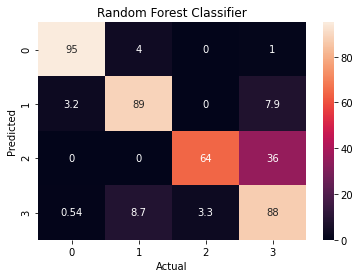

In [49]:
import seaborn as sns

#Finally let's see where model is getting confused through a ConfusionMatrix
rf_cm = confusion_matrix(y_test,RF_preds)

rf_cm = rf_cm.astype('float') / rf_cm.sum(axis=1)[:,np.newaxis]
rf_cm = rf_cm * 100

#esrb_rating_labels
labels = le.classes_
sns.heatmap(rf_cm,annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Classifier')
plt.show()